# 
We hypothesize that stimulus-evoked changes in the LFP aperiodic offset reflect increased spiking activity in the underlying population. This notebook will investigate this hypothesis by computing stimulus-evoked changes in multi-unit spiking activity (MUA), and integrating these results with our previous spectral parameter results.  

## Set-up

#### Set path

In [1]:
# Define paths
PROJECT_PATH = r'G:\Shared drives\v1_v4_1024'


#### Imports

In [2]:
# general
import numpy as np
import matplotlib.pyplot as plt
import os
from neurodsp.utils import create_times
import pandas as pd
from scipy.stats import linregress

# custom
import sys
sys.path.append("../")
from scripts.utils import load_nix, epoch_neo_segment
from scripts.plots import plot_schematic


#### Settings

In [3]:
# Session of interest (will ultimately apply to all sessions)
SESSIONS = ["A_SNR_041018", "A_SNR_140819", "L_SNR_250717"]
SESSION = "A_SNR_140819"

In [4]:
# Dataset details
N_CHANS = 64 # number of channels per array
N_ARRAYS = 16 # number of arrays per session
DURATION = 0.3 # duration of pre-/post-stimulus epoch (s)
T_MIN = -0.3 # minimum time (s)

#### Functions

## Main

#### Create output directory

In [5]:
dir_out = f"{PROJECT_PATH}/figures/"
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

#### load data

In [6]:
# load LFP spectral parameter results
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\lfp_spectral_params.csv", index_col=0)
results

,session,channel,chan_idx,array,epoch,offset,knee,exponent,r2
0,A_SNR_140819,0,0,1,pre,8.250311,5413.753566,3.660094,0.998489
1,A_SNR_140819,1,1,1,pre,8.123542,5823.332260,3.641594,0.998853
2,A_SNR_140819,2,2,1,pre,7.435896,1192.282733,3.096264,0.994847
3,A_SNR_140819,3,3,1,pre,8.042354,5815.934643,3.603246,0.998999
4,A_SNR_140819,4,4,1,pre,7.885415,4011.087422,3.485834,0.998878
...,...,...,...,...,...,...,...,...,...
4091,L_SNR_250717,59,1019,16,post,8.072765,368.888266,2.765816,0.998221
4092,L_SNR_250717,60,1020,16,post,8.280201,823.197397,2.800549,0.999511
4093,L_SNR_250717,61,1021,16,post,8.571924,1261.398404,2.944253,0.999020
4094,L_SNR_250717,62,1022,16,post,8.790193,2288.213887,3.043717,0.998485


#### demo importing and plotting MUA data

Sampling rate: 1000.0 Hz
Signal duration: 0.064 s
N channels: 64
N trials: 102


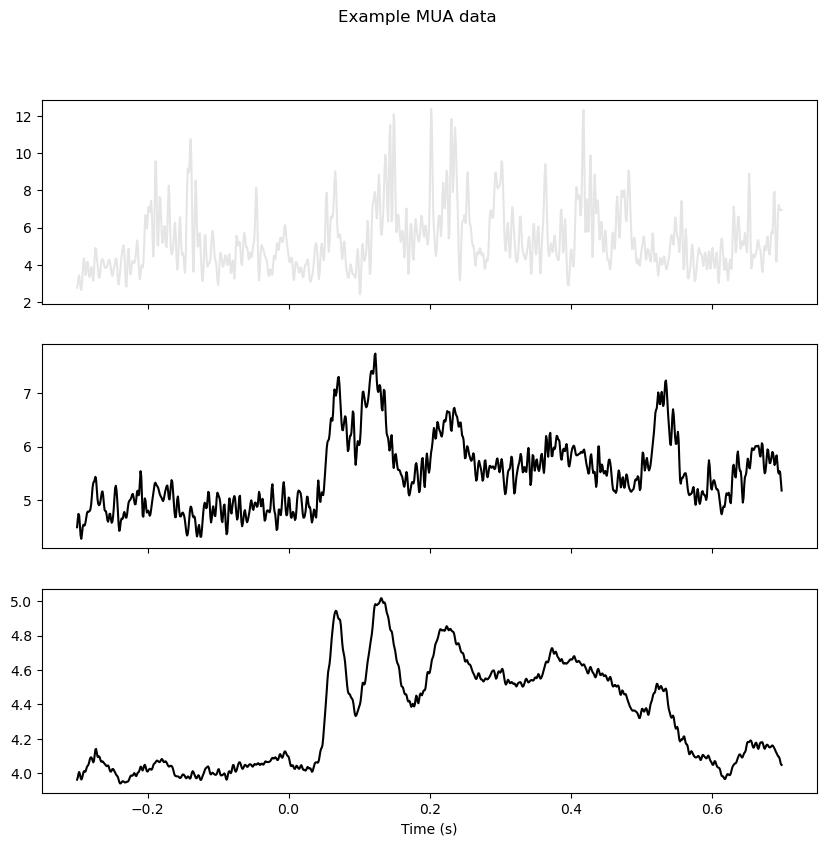

In [8]:
# load example MUA data
fname_in = r"G:\Shared drives\v1_v4_1024\data\dataset\A_SNR_041018\mua\NSP1_array1_MUAe.nix"
segment, analog_signal = load_nix(fname_in)
signal = segment.analogsignals[0].T # transpose to get channels x time
fs = analog_signal._sampling_rate.item()

# epoch data into trials around stimulus times
epochs = epoch_neo_segment(segment, reset_time=True) 
epoch_times = create_times(epochs.shape[-1]/fs, fs, start_val=T_MIN) # get times for each epoch

# print info
print(f"Sampling rate: {fs} Hz")
print(f"Signal duration: {signal.duration.item()} s")
print(f"N channels: {signal.shape[0]}")
print(f"N trials: {len(segment.epochs[0])}")

# plot example trial, example channel, and grand average
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=[10,9], sharex=True)
fig.suptitle(f"Example MUA data")
ax1.plot(epoch_times, epochs[0,0,:].T, color="k", alpha=0.1) # plot first trial
ax2.plot(epoch_times, epochs[:,10,:].mean(axis=0), color="k") # plot first channel (mean across trials)
ax3.plot(epoch_times, epochs.mean(axis=(0,1)), color="k") # plot mean across all trials and channels
ax3.set_xlabel("Time (s)")
plt.show()


#### Compute average MUA for the pre-stimulus (-0.3 to 0.0 s) and post-stimulus (0.0 to 0.3 s) period.
add this information to the results dataframe imported above

In [ ]:
## in epochs we originally have channels x time x trials
# with np.mean(epochs, axis=0) we are averaging the trials such that we now have a mean for each channel in all the time points
# so mua_mean.shape is (64,1000)

In [25]:
# average MUA over channels
mua_mean = np.mean(epochs, axis=0) # channels x time
print("mua shape:", mua_mean.shape)
print("epoch_times shape:", epoch_times.shape)


# find indices
idx_pre = np.logical_and(epoch_times>=(0-DURATION), epoch_times<(0))
print("n sample pre:", np.sum(idx_pre))
idx_post = np.logical_and(epoch_times>=(0), epoch_times<(DURATION)) 
print("n sample post:", np.sum(idx_post))
mua_pre_array = mua_mean[:, idx_pre] # index time dimension
print(mua_pre_array.shape)
# mua_post 
mua_post_array = mua_mean[:, idx_post] # index time dimension
print(mua_post_array.shape)

# take average over each window
mua_pre = np.mean(mua_pre_array, axis=1)
print("mua pre shape", mua_pre.shape)

mua_post = np.mean(mua_post_array, axis=1)
print("mua pre shape", mua_post.shape)

mua shape: (64, 1000)
epoch_times shape: (1000,)
n sample pre: 300
n sample post: 300
(64, 300)
(64, 300)
mua pre shape (64,)
mua pre shape (64,)


In [6]:
# compute average MUA for pre- and post-stimulus epochs, across all sessions

# init
dfs =[]

# loop through epochs
for session in SESSIONS:
    for i_array in range(N_ARRAYS):
        nps_idx = (i_array+2) // 2

        # display progress
        fname_in = f"{PROJECT_PATH}/data/dataset/{session}/mua/NSP{nps_idx}_array{i_array+1}_MUAe.nix"
        print(f"current file: {fname_in}")
        
        # create dataframe for session data
        data = {
            'session'   :   np.repeat(session, N_CHANS),
            'array'     :   np.repeat(i_array, N_CHANS) + 1,
            'channel'   :   np.concatenate([np.arange(N_CHANS)])}
        
        segment, analog_signal = load_nix(fname_in)
        signal = segment.analogsignals[0].T # transpose to get channels x time
        fs = analog_signal._sampling_rate.item()

        # epoch data into trials around stimulus times
        epochs = epoch_neo_segment(segment, reset_time=True) 
        epoch_times = create_times(epochs.shape[-1]/fs, fs, start_val=T_MIN) # get times for each epoch

        # average MUA over trials
        mua_mean = np.mean(epochs, axis=0) # channels x time
        
        # find indices for pre- and post-stimulus epochs
        idx_pre = np.logical_and(epoch_times>=(0-DURATION), epoch_times<(0))
        idx_post = np.logical_and(epoch_times>=(0), epoch_times<(DURATION)) 

        # loop through epochs 
        for epoch, indices in zip(['pre', 'post'], [idx_pre, idx_post]):
            df_ar = pd.DataFrame(data=data)
            df_ar['epoch'] = epoch

            # index time dimension
            mua_array = mua_mean[:, indices]

            # take average over time window
            df_ar[f'mua'] = np.mean(mua_array, axis=1)

            # add results to list
            dfs.append(df_ar)

# concatenate results into single dataframe
df = pd.concat(dfs, ignore_index=True)

current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP1_array1_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP1_array2_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP2_array3_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP2_array4_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP3_array5_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP3_array6_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP4_array7_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP4_array8_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP5_array9_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/mua/NSP5_array10_MUAe.nix
current file: G:\Shared drives\v1_v4_1024/data/dataset/A_SNR_041018/m

In [7]:
# save results
df.to_csv(f'{PROJECT_PATH}/data/results/mua_df.csv')

#### Plot the stimulus-evoked change in the MUA v. the change in the LFP offset.

In [ ]:
# get dataframe from spectral_params_diff.csv for offset diff
# use the notebook to see also how to calculate diff in mua
# for plotting 
# correlate_specparam_erp scatterplot for plotting diff in both offset and mua

In [7]:
# load data
df = pd.read_csv(f'{PROJECT_PATH}/data/results/mua_df.csv', index_col=0)
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\lfp_spectral_params.csv", index_col=0) # load LFP spectral parameter results

# merge both dataframes
results_df = pd.merge(left=results, right=df, on= ["session", "array", "channel", "epoch"])

In [8]:
# calculate change in variables
df_post = results_df.loc[results_df["epoch"]=="post"]
df_pre = results_df.loc[results_df["epoch"]=="pre"]

df_merge = df_post.merge(df_pre, on=['session','channel','chan_idx','array'], suffixes=['_post', '_pre'])
df_merge = df_merge.drop(columns=['epoch_pre','epoch_post'])

varname = ['offset', 'knee', 'exponent', 'r2', 'mua']
for var in varname : 
    df_merge[f'{var}_diff'] = df_merge[f'{var}_post'] - df_merge[f'{var}_pre']


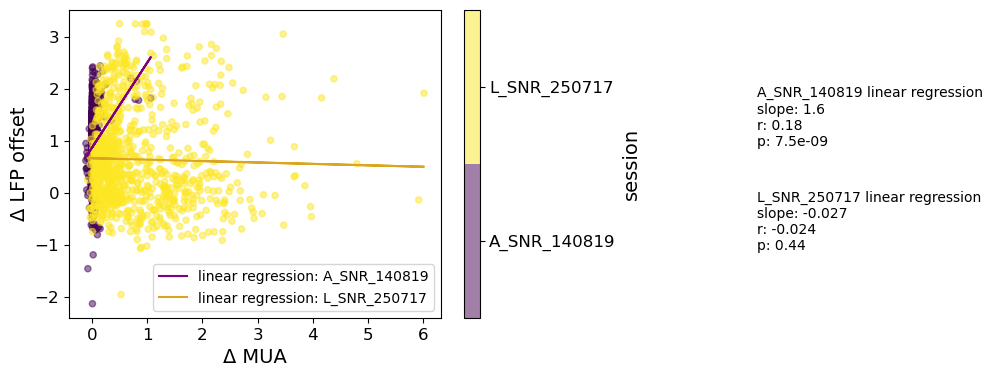

In [42]:
# temporary variable due to df_merge being 2 sessions instead of 3
SESSIONS = ["A_SNR_140819", "L_SNR_250717"]
colors = ["purple", "goldenrod"]

# plot change in mua vs change in offset
df_merge['session'] = pd.Categorical(df_merge['session'])
fig, ax = plt.subplots(1,1, figsize=[6,4])
df_merge.plot.scatter(x="mua_diff", y="offset_diff", c="session", cmap="viridis", alpha=0.5, ax=ax)
ax.set(xlabel="\u0394 MUA", ylabel="\u0394 LFP offset")

# add linear regression per session
for session, color, offset in zip(SESSIONS, colors, [0,2]):
    results_session = df_merge.loc[df_merge["session"]==session]

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x=results_session["mua_diff"], y=results_session["offset_diff"])
    y_pred = intercept + slope*results_session["mua_diff"]

    label = f"{session} linear regression \nslope: {slope:.2} \nr: {rvalue:.2} \np: {pvalue:.2}"
    ax.plot(results_session["mua_diff"],y_pred, color=color, label=f"linear regression: {session}")
    plt.text(12.05, 0.9 - offset, label)

ax.legend()
plt.show()

ax.figure.savefig(fr"{PROJECT_PATH}\figures\linregress_offset_mua.png")


In [56]:
lims = np.append(df_merge[f"mua_pre"], df_merge[f"mua_post"])
maxli = np.nanmax(lims)
maxli

41.50185569277813

warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
Validation found 0 errors and 1 warnings in 0 Sections and 1 Properties.
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element 

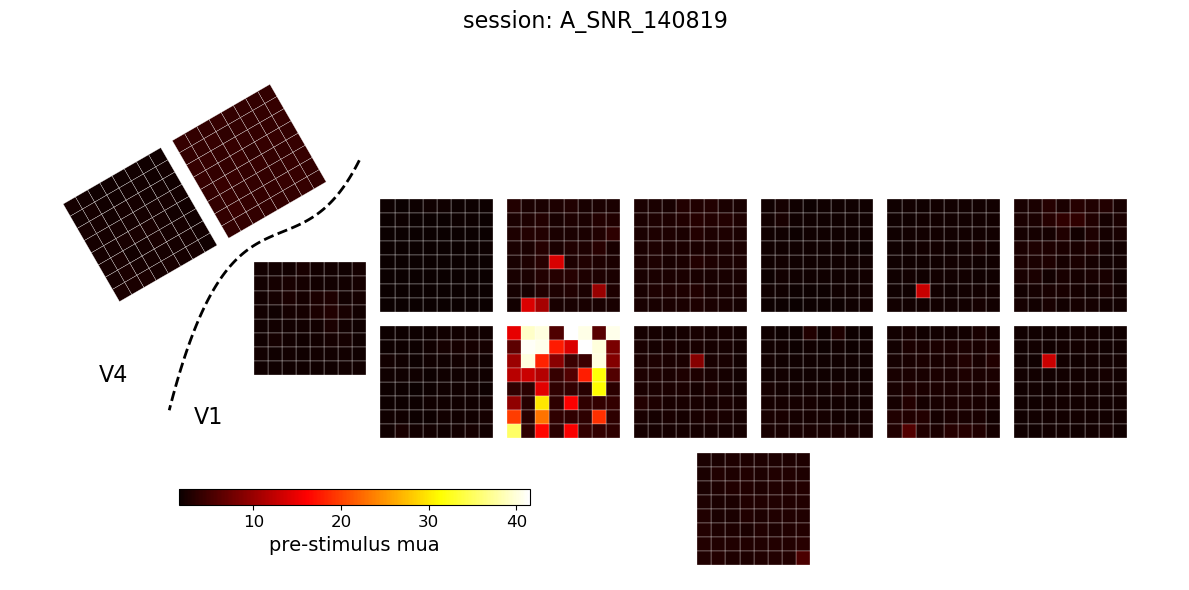

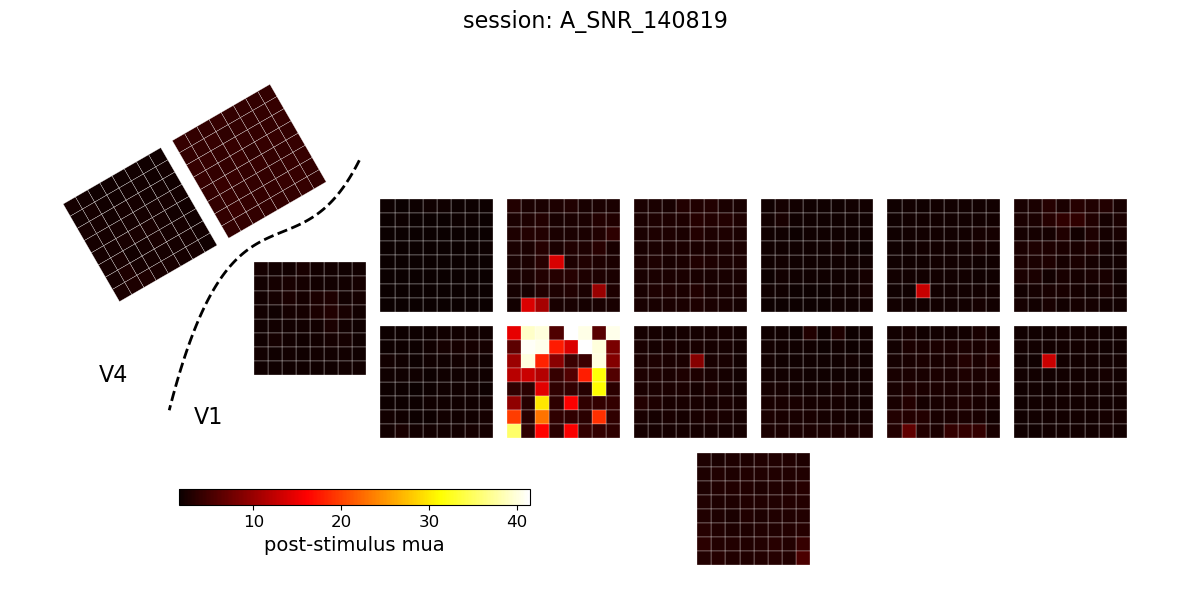

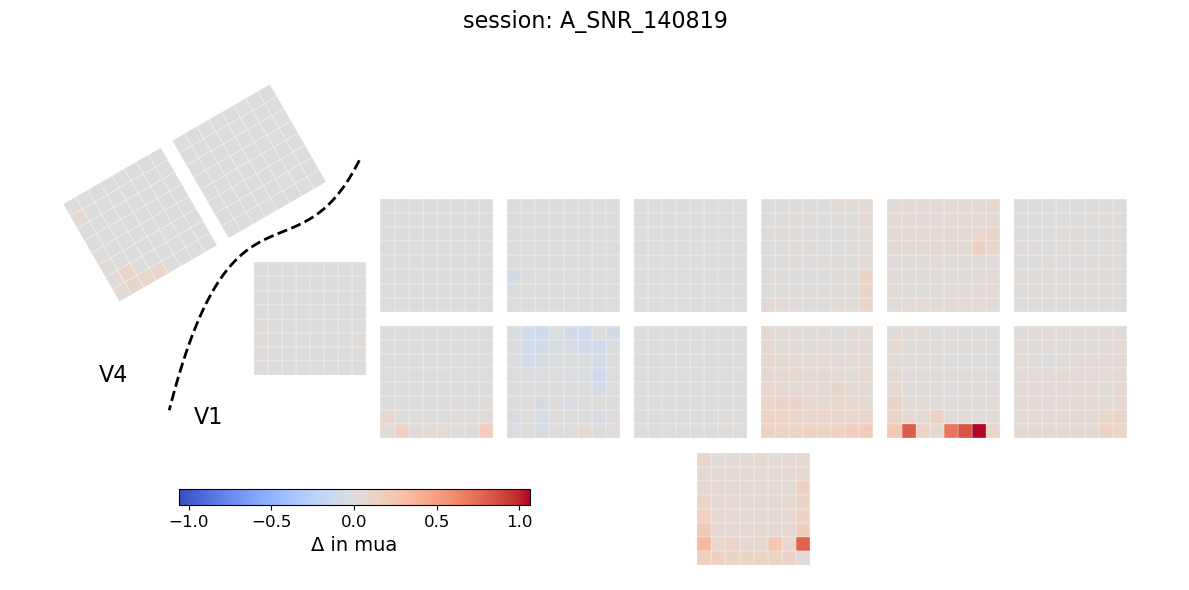

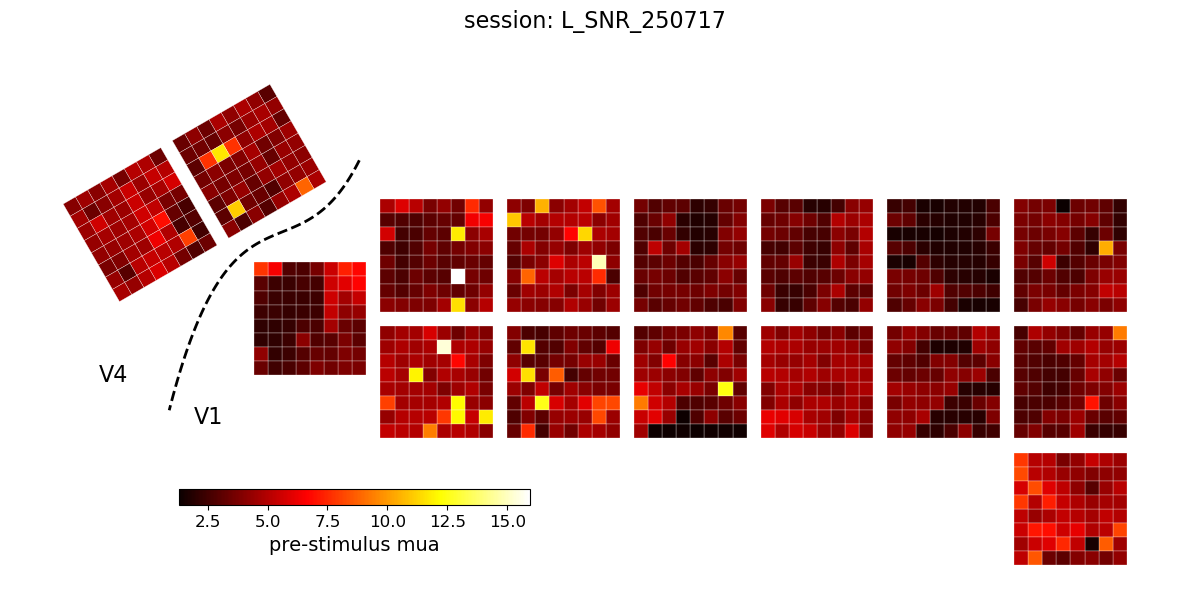

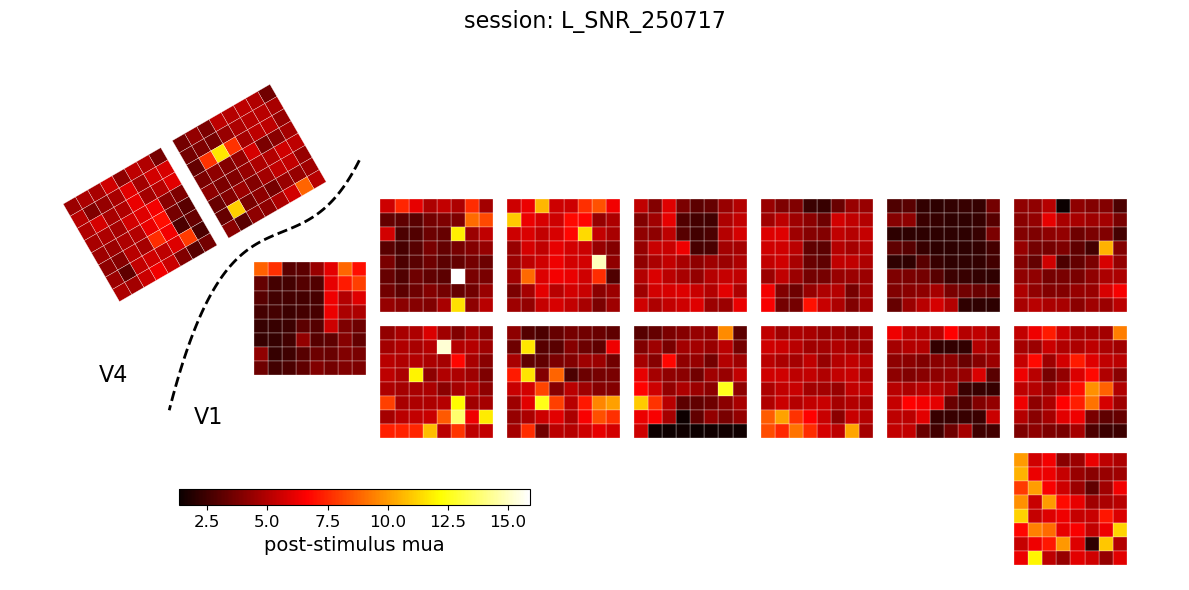

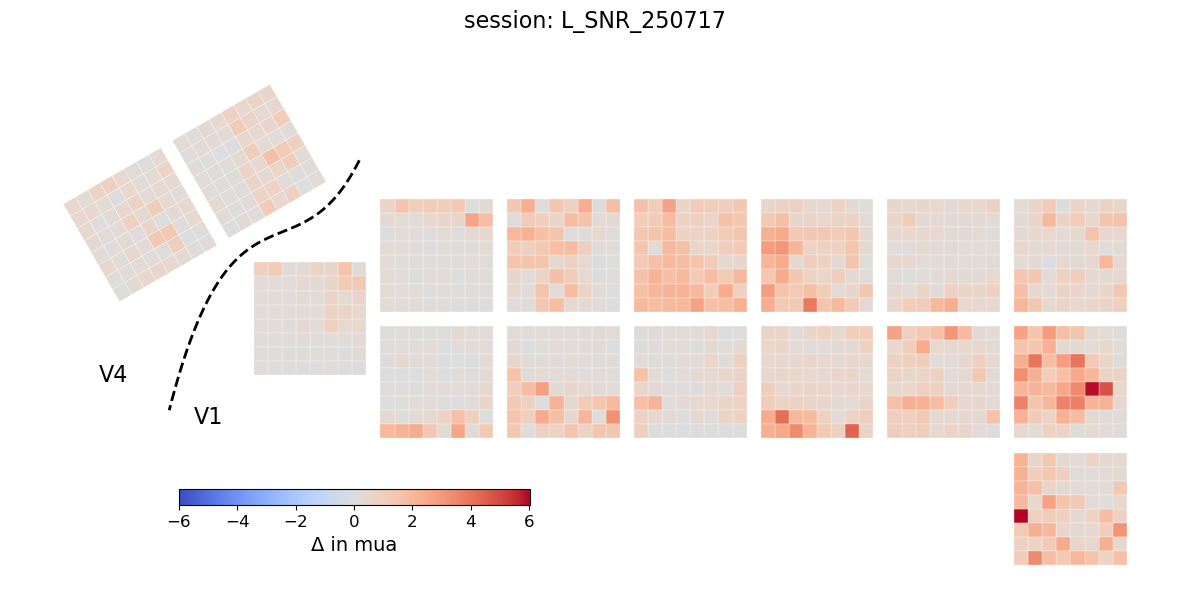

In [28]:
# plot shematic for mua pre, post and diff

for session in SESSIONS : 
    # get data for session
        df_session = df_merge[df_merge['session']==session]

        # define odml file path (contains metadata including electrode positions)
        odml_path = fr"{PROJECT_PATH}\data\dataset\{session}\metadata_{session}.odml"

        # setting limits for colorbar
        #lims = np.append(df_session[f"mua_pre"], df_session[f"mua_post"])
        #maxli = np.nanmax(lims)
        #minli = np.nanmin(lims)
        
        # pre-stimulus
        plot_schematic(df_session[f"mua_pre"], odml_path, title=f"session: {session}", 
                       label=f"pre-stimulus mua", #vmin=minli, vmax=maxli, 
                       fname_out=f"{dir_out}/{session}_mua_pre.png");

        # post-stimulus
        plot_schematic(df_session[f"mua_post"], odml_path, title=f"session: {session}", 
                       label=f"post-stimulus mua", #vmin=minli, vmax=maxli, 
                       fname_out=f"{dir_out}/{session}_mua_post.png");

        # change in exponent
        diff = df_session[f"mua_post"] - df_session[f"mua_pre"]
        plot_schematic(diff, odml_path, norm_type="centered", title=f"session: {session}", 
                       label=f"\u0394 mua", #vmin=np.nanmin(diff), vmax=np.nanmax(diff), 
                       fname_out=f"{dir_out}/{session}_mua_diff.png");
